In [1]:
import scvi
import anndata as ad
import scanpy as sc

In [3]:
scvi.settings.seed = 0

Seed set to 0


In [ ]:
raw_adata =  ad.read_h5ad('Data/GSE155249_COUNTS_NOT_NORMALIZED_FIXED.h5ad')
raw_adata

AnnData object with n_obs × n_vars = 77146 × 20692
    obs: 'barcode_name', 'Sample', 'Cluster'
    var: 'gene_name'
    layers: 'counts'

In [ ]:
main_adata = ad.read_h5ad('Data/GSE155249_main.h5ad')

In [3]:
main_adata

AnnData object with n_obs × n_vars = 77146 × 21819
    obs: 'Patient', 'Day after intubation', 'Sample type', 'Sample', 'Sample status', 'Cluster', 'COVID-19', 'No of SARS-CoV-2 genes', 'IFNA Response', 'IFNG Response', 'No of genes', 'No of UMIs', '% of mito genes', '% of ribo genes'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'n_cells-18', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', '

In [8]:
main_adata.var['highly_variable']

A1BG        False
A1BG-AS1    False
A2M          True
A2M-AS1     False
A2ML1       False
            ...  
ZXDC         True
ZYG11A      False
ZYG11B      False
ZYX         False
ZZEF1       False
Name: highly_variable, Length: 21819, dtype: bool

In [9]:
new_gene_list = [item.replace('GRCh38______', '') for item in list(raw_adata.var['gene_name'].values)]
new_gene_list[:5]

['SHC1', 'CDR1', 'AC118553.2', 'HIST1H2AB', 'KIF27']

In [10]:
len(new_gene_list)

20692

In [11]:
raw_adata.var['highly_variable'] = False  

In [12]:
raw_adata.var['highly_variable']

GRCh38______SHC1          False
GRCh38______CDR1          False
GRCh38______AC118553.2    False
GRCh38______HIST1H2AB     False
GRCh38______KIF27         False
                          ...  
GRCh38______PSMB7         False
GRCh38______LINC00265     False
GRCh38______MEG8          False
GRCh38______PSMG3         False
GRCh38______RASGRP3       False
Name: highly_variable, Length: 20692, dtype: bool

In [13]:
raw_adata.var['highly_variable'] = False  

for gene in new_gene_list:
    raw_adata.var.loc['GRCh38______' + gene, 'highly_variable'] = bool(main_adata.var.loc[gene, 'highly_variable'])

In [14]:
raw_adata

AnnData object with n_obs × n_vars = 77146 × 20692
    obs: 'barcode_name', 'Sample', 'Cluster'
    var: 'gene_name', 'highly_variable'
    layers: 'counts'

In [15]:
raw_adata.var['highly_variable']

GRCh38______SHC1          False
GRCh38______CDR1          False
GRCh38______AC118553.2     True
GRCh38______HIST1H2AB     False
GRCh38______KIF27          True
                          ...  
GRCh38______PSMB7         False
GRCh38______LINC00265     False
GRCh38______MEG8          False
GRCh38______PSMG3         False
GRCh38______RASGRP3        True
Name: highly_variable, Length: 20692, dtype: bool

In [ ]:
sc.write('Data/GSE155249_COUNTS_NOT_NORMALIZED_FIXED.h5ad', raw_adata)

In [17]:
raw_adata.var['highly_variable'].value_counts()

highly_variable
False    16323
True      4369
Name: count, dtype: int64

In [18]:
main_adata.var['highly_variable'].value_counts()

highly_variable
False    17331
True      4488
Name: count, dtype: int64

In [19]:
raw_adata_hvg = raw_adata[:, raw_adata.var['highly_variable']]
raw_adata_hvg

View of AnnData object with n_obs × n_vars = 77146 × 4369
    obs: 'barcode_name', 'Sample', 'Cluster'
    var: 'gene_name', 'highly_variable'
    layers: 'counts'

In [21]:
sc.pp.highly_variable_genes(
    raw_adata_hvg,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="Sample"
)
raw_adata_hvg

/raid/brunopsz/Moddeling/Env/scvi_new/lib/python3.13/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


AnnData object with n_obs × n_vars = 77146 × 1200
    obs: 'barcode_name', 'Sample', 'Cluster'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

In [22]:
scvi.model.SCVI.setup_anndata(raw_adata_hvg, layer="counts", batch_key="Sample")

In [23]:
model = scvi.model.SCVI(raw_adata_hvg, n_layers=2, n_latent=10, gene_likelihood="nb")

In [24]:
import torch
torch.cuda.set_device(1)

In [25]:
model.train()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/raid/brunopsz/Moddeling/Env/scvi_new/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=119` in the `DataLoader` to improve performance.


Training:   0%|          | 0/104 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=104` reached.


In [26]:
SCVI_LATENT_KEY = "X_scVI"
raw_adata_hvg.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [27]:
raw_adata_hvg

AnnData object with n_obs × n_vars = 77146 × 1200
    obs: 'barcode_name', 'Sample', 'Cluster', '_scvi_batch', '_scvi_labels'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI'
    layers: 'counts'

In [28]:
sc.pp.neighbors(raw_adata_hvg, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(raw_adata_hvg, min_dist=0.3)

Text(0.5, 0.98, 'UMAP of SCVI Representation')

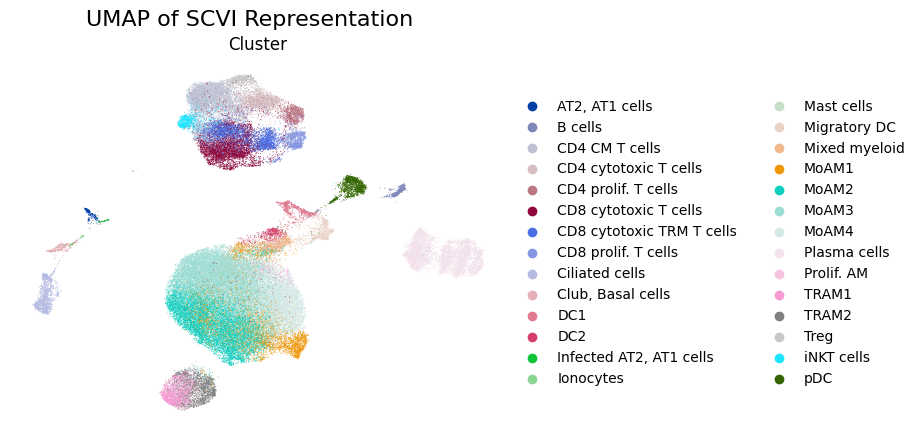

In [29]:
fig = sc.pl.umap(
    raw_adata_hvg,
    color=["Cluster"],
    frameon=False,
    ncols=1,
    return_fig=True,
)

fig.suptitle("UMAP of SCVI Representation", fontsize=16)


Text(0.5, 0.98, 'UMAP of SCVI Representation (batch effect)')

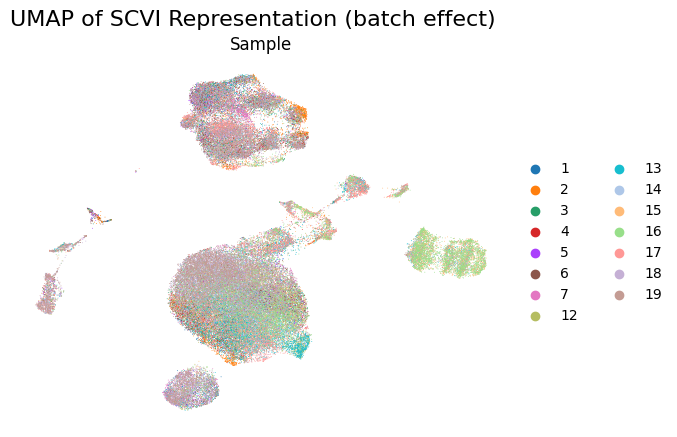

In [30]:
fig = sc.pl.umap(
    raw_adata_hvg,
    color=["Sample"],
    frameon=False,
    ncols=1,
    return_fig=True,
)

fig.suptitle("UMAP of SCVI Representation (batch effect)", fontsize=16)

In [32]:
model.save("scvi_model_10", overwrite=True)

In [34]:
# model = scvi.model.SCVI.load("scvi_model_10/", adata=raw_adata_hvg)

In [35]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=raw_adata_hvg,
    labels_key="Cluster",
    unlabeled_category="Unknown",
)

In [36]:
scanvi_model.train(max_epochs=20)

INFO     Training for 20 epochs.                                                                                   


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/raid/brunopsz/Moddeling/Env/scvi_new/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=119` in the `DataLoader` to improve performance.


Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [38]:
SCANVI_LATENT_KEY = "X_scANVI"
raw_adata_hvg.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation()

In [39]:
raw_adata_hvg

AnnData object with n_obs × n_vars = 77146 × 1200
    obs: 'barcode_name', 'Sample', 'Cluster', '_scvi_batch', '_scvi_labels'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'Cluster_colors', 'Sample_colors'
    obsm: 'X_scVI', 'X_umap', 'X_scANVI'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [40]:
sc.pp.neighbors(raw_adata_hvg, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(raw_adata_hvg, min_dist=0.3)

Text(0.5, 0.98, 'UMAP of SCANVI Representation')

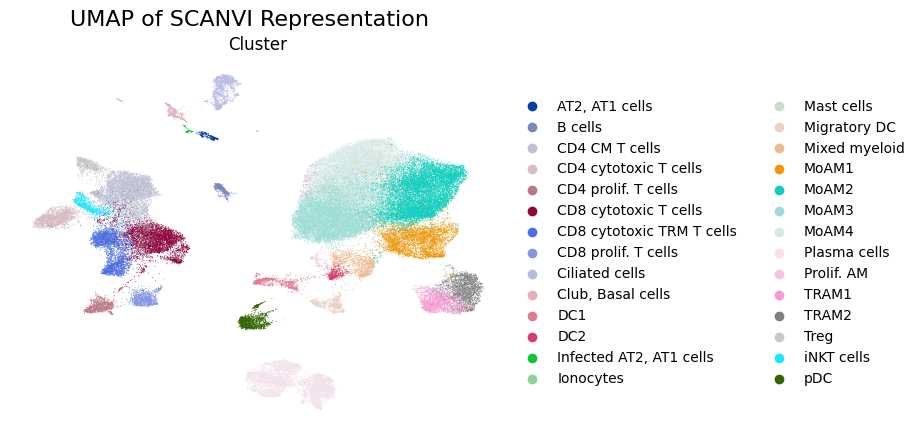

In [41]:
fig = sc.pl.umap(
    raw_adata_hvg,
    color=["Cluster"],
    frameon=False,
    ncols=1,
    return_fig=True,
)

fig.suptitle("UMAP of SCANVI Representation", fontsize=16)

In [ ]:
sc.write('DATA/ANNDATAS/adata_scanvi_1200.h5ad', raw_adata_hvg)

### Now let's prepare scanvi anndata form 4369 HVG 

In [44]:
raw_adata

AnnData object with n_obs × n_vars = 77146 × 20692
    obs: 'barcode_name', 'Sample', 'Cluster'
    var: 'gene_name', 'highly_variable'
    layers: 'counts'

In [45]:
raw_adata_hvg = raw_adata[:, raw_adata.var['highly_variable']]
raw_adata_hvg

View of AnnData object with n_obs × n_vars = 77146 × 4369
    obs: 'barcode_name', 'Sample', 'Cluster'
    var: 'gene_name', 'highly_variable'
    layers: 'counts'

In [47]:
raw_adata_hvg = raw_adata_hvg.copy()

In [48]:
scvi.model.SCVI.setup_anndata(raw_adata_hvg, layer="counts", batch_key="Sample")

In [49]:
import torch
torch.cuda.set_device(1)

In [50]:
model = scvi.model.SCVI(raw_adata_hvg, n_layers=2, n_latent=10, gene_likelihood="nb")
model.train()
SCVI_LATENT_KEY = "X_scVI"
raw_adata_hvg.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/raid/brunopsz/Moddeling/Env/scvi_new/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=119` in the `DataLoader` to improve performance.


Training:   0%|          | 0/104 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=104` reached.


In [51]:
raw_adata_hvg

AnnData object with n_obs × n_vars = 77146 × 4369
    obs: 'barcode_name', 'Sample', 'Cluster', '_scvi_batch', '_scvi_labels'
    var: 'gene_name', 'highly_variable'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI'
    layers: 'counts'

In [52]:
model.save("scvi_model_10_4369_hvg", overwrite=True)

In [53]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=raw_adata_hvg,
    labels_key="Cluster",
    unlabeled_category="Unknown",
)

scanvi_model.train(max_epochs=20)

SCANVI_LATENT_KEY = "X_scANVI"
raw_adata_hvg.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation()

INFO     Training for 20 epochs.                                                                                   


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/raid/brunopsz/Moddeling/Env/scvi_new/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=119` in the `DataLoader` to improve performance.


Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [55]:
raw_adata_hvg.obsm[SCANVI_LATENT_KEY].shape

(77146, 10)

In [ ]:
sc.write('DATA/ANNDATAS/adata_scanvi_4369.h5ad', raw_adata_hvg)